## Initial EDA 

*Author: Chris Barton*

Dataset Specifications 

- 25 Million Rows
- 12 Features
    - Features are unknown for privacy reasons. Additionally, the are projected as to keep predictive power, while making it extremely difficult to deduce what they originally were. 
- 2 binary labels
    - Visits
    - Conversions
- Global Treatment Ratio: 84.6%



In [2]:
import google.datalab.bigquery as bq

query="""
SELECT COUNT(*) as total_rows
FROM `uplift.data`
"""


df = bq.Query(query).execute().result().to_dataframe()
df.head()

,total_rows
0,25309482


In [14]:
query="""
SELECT *
FROM `uplift.data`
ORDER BY RAND()
LIMIT 1000000
"""

df = bq.Query(query).execute().result().to_dataframe()
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,1.991981,3.263641,8.617092,3.735871,3.506733,10.161281,2.981721,-0.166689,-13.903629,15.995971,-1.8609,4.157648,1,0,0,0
1,-0.561010,3.263641,8.272483,3.735871,3.506733,10.161281,1.367787,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0,0,0
2,0.021456,3.263641,8.944919,2.773423,3.506733,10.161281,-2.931787,-0.166689,-7.569716,9.850093,-1.8609,4.157648,1,0,0,0
3,1.991981,3.263641,8.894464,3.735871,3.506733,10.161281,2.981721,-0.166689,-1.784858,9.850093,-1.8609,4.157648,0,0,0,0
4,1.991981,3.263641,8.272483,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0,0,0


Above we can see each of the features (f0 - f11) are numeric and continous in nature. Below, we will look at some descriptive statistics for each feature. 

In [15]:
df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.619580,3.265677,8.507953,3.656470,3.522720,10.201708,1.755504,-0.293643,-2.060825,10.671198,-2.095525,4.159091,0.846752,0.002275,0.041514,0.034716
std,1.535427,0.023321,0.359446,0.241653,0.109257,0.232673,1.673622,0.665434,5.474330,2.293606,1.393061,0.016990,0.360227,0.047643,0.199476,0.183060
min,-1.946280,3.263641,8.272483,1.119173,3.506733,10.161281,-7.895208,-4.724843,-32.887170,9.850093,-13.038111,4.157648,0.000000,0.000000,0.000000,0.000000
25%,-1.006548,3.263641,8.272483,3.735871,3.506733,10.161281,0.945163,-0.166689,-2.716012,9.850093,-1.860900,4.157648,1.000000,0.000000,0.000000,0.000000
50%,1.634821,3.263641,8.272483,3.735871,3.506733,10.161281,2.386066,-0.166689,1.107571,9.850093,-1.860900,4.157648,1.000000,0.000000,0.000000,0.000000
75%,1.991981,3.263641,8.759536,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.860900,4.157648,1.000000,0.000000,0.000000,0.000000
max,1.991981,4.502868,9.337055,3.735871,7.797549,16.905250,2.981721,-0.166689,1.107571,28.732895,-1.860900,5.194567,1.000000,1.000000,1.000000,1.000000


In [20]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

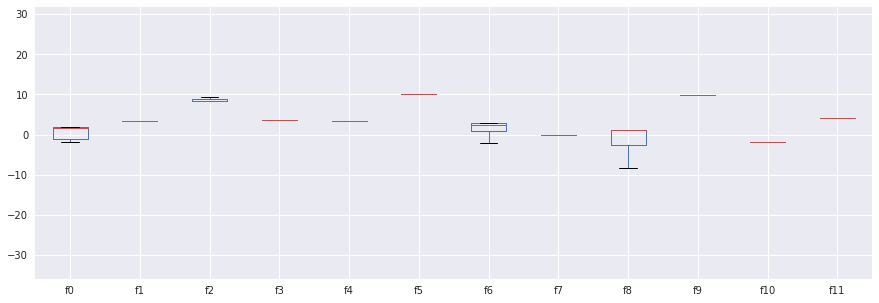

In [21]:
df.boxplot(column=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11'])

In [ ]:
df[['treatment','conversion','visit', 'exposure']].plot.bar(rot=0)

1. Sanity Check 1
    - No users in the control population should be exposed to ads during the test.
    
   Confirmed with query below. 

In [16]:
query="""
SELECT COUNT(*) as treatment_and_exposure
FROM `uplift.data`
WHERE treatment = 0 AND exposure = 1
"""

df = bq.Query(query).execute().result().to_dataframe()
df.head()

,treatment_and_exposure
0,0


In [18]:
query="""
SELECT treatment, COUNT(*) AS cnt 
FROM `uplift.data`
GROUP BY treatment
"""

df = bq.Query(query).execute().result().to_dataframe()
df.head()

,treatment,cnt
0,1,21408827
1,0,3900655


2. Sanity Check Two
    - Features should be independent of treatment / control group. If not, there was a problem with the randomization strategy. 

In [11]:
query="""
SELECT f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11, treatment FROM `uplift.data` b ORDER BY RAND() LIMIT 200000
"""

df = bq.Query(query).execute().result().to_dataframe()
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment
0,-1.934090,3.263641,8.272483,3.735871,3.506733,10.161281,-0.606249,-0.166689,1.107571,9.850093,-1.860900,4.157648,1
1,1.991981,3.263641,9.177228,3.735871,3.803153,10.161281,2.981721,-0.166689,-11.976511,9.850093,-12.475857,4.157648,0
2,-1.708783,3.263641,8.272483,3.735871,3.506733,10.161281,2.386066,-0.166689,1.107571,9.850093,-1.860900,4.157648,1
3,-1.310403,3.263641,8.286953,3.735871,3.506733,10.161281,1.963442,-0.166689,-4.120075,12.782422,-1.860900,4.157648,1
4,1.991981,3.263641,8.272483,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.860900,4.157648,1


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import hamming_loss
from scipy import stats

In [12]:
clf=LogisticRegression()
loss=hamming_loss
bootstraps=300

X_train, X_test, y_train, y_test = train_test_split(df[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']], df['treatment'], test_size=0.33, random_state=35)

y_pred = clf.fit(X_train, y_train).predict(X_test)
emp_loss = loss(y_test, y_pred)
bs_losses = []
y_bar = np.mean(df['treatment'])

for b in range(500+1):
    y_random = np.random.binomial(1, y_bar, size=df['treatment'].shape[0])
    X_train, X_test, y_train, y_test = train_test_split(df[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']], y_random)
    y_pred_bs = clf.fit(X_train, y_train).predict(X_test)
    bs_losses += [loss(y_test, y_pred_bs)]
    
pc = stats.percentileofscore(sorted(bs_losses), emp_loss) / 100.
pvalue = pc if pc < y_bar else 1 - pc

In [13]:
print("Loss of classifier trained on treatment variable of full dataset: %s" % emp_loss)
print("Average loss of classifers trained on random treatment variable: %s" % (np.mean(bs_losses)))

Loss of classifier trained on treatment variable of full dataset: 0.15472727272727274
Average loss of classifers trained on random treatment variable: 0.1546344111776447


In [14]:
stats.ttest_1samp(bs_losses, emp_loss)

Ttest_1sampResult(statistic=-1.2076030741476238, pvalue=0.22777088838058449)

Text(0.5,0,u'Hamming Loss')

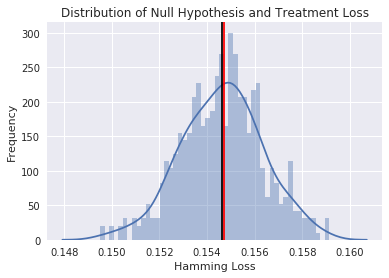

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(bs_losses, bins=50)
plt.axvline(emp_loss, color='r')
# plt.text(emp_loss+.1,0,'Treatment loss',rotation=90)
plt.axvline(np.mean(bs_losses), color='black')
plt.title("Distribution of Null Hypothesis and Treatment Loss")
plt.ylabel("Frequency")
plt.xlabel("Hamming Loss")

In [30]:
query="""
SELECT f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11, treatment, conversion 
FROM `uplift.data` b ORDER BY RAND() LIMIT 200000
"""

df = bq.Query(query).execute().result().to_dataframe()
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion
0,-1.646298,3.263641,8.272483,3.735871,3.506733,10.161281,2.386066,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0
1,1.991981,3.263641,8.272483,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0
2,-0.721902,3.263641,8.272483,3.735871,3.506733,10.161281,1.367787,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0
3,-1.260960,3.263641,8.272483,3.735871,3.506733,10.161281,-0.895229,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0
4,1.991981,3.263641,8.272483,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0


In [48]:
print("Percent of dataset that has a conversion: %s" % (df['conversion'].sum() / 200000.))

Percent of dataset that has a conversion: 0.00248


In [51]:
X_train, X_test, y_train, y_test = train_test_split(df[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']], df['conversion'], test_size=0.33, random_state=35)

clf=LogisticRegression(class_weight="balanced")

y_pred = clf.fit(X_train, y_train).predict(X_test)
wholedataset_loss = loss(y_test, y_pred)

X_train, X_test, y_train, y_test = train_test_split(df[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']][df.treatment == 1], df['conversion'][df.treatment == 1], test_size=0.33, random_state=35)

y_pred = clf.fit(X_train, y_train).predict(X_test)
treatmeant_loss = loss(y_test, y_pred)

X_train, X_test, y_train, y_test = train_test_split(df[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']][df.treatment == 0], df['conversion'][df.treatment == 0], test_size=0.33, random_state=35)

y_pred = clf.fit(X_train, y_train).predict(X_test)
control_loss = loss(y_test, y_pred)

# baseline
y_bar = np.mean(df['conversion'])
y_random = np.random.binomial(1, y_bar, size=df['conversion'].shape[0])
X_train, X_test, y_train, y_test = train_test_split(df[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']], y_random)
y_pred_bs = clf.fit(X_train, y_train).predict(X_test)
baseline = loss(y_test, y_pred_bs)


In [56]:

def improvement(baseline, new):
  return (new - baseline) / baseline * 100 

print("Hamming Loss on Various Classifiers")
print("Loss of whole dataset: %s" %  wholedataset_loss)
print("Loss of treatment: %s" %  treatmeant_loss)
print("Loss of control: %s" %  control_loss)
print("Loss of baseline: %s" %  baseline)
print("")
print("Log-loss Improvement over baseline")
print("Log-Loss impovement of whole dataset: %s" % improvement(np.log(baseline), np.log(wholedataset_loss))) #np.log(wholedataset_loss))
print("Log-Loss impovement of treatment: %s" % improvement(np.log(baseline), np.log(treatmeant_loss)))# np.log(treatmeant_loss))
print("Log-Loss impovement of control: %s" % improvement(np.log(baseline), np.log(control_loss)))# np.log(control_loss))
print("Log-Loss impovement of baseline: %s" % improvement(np.log(baseline), np.log(baseline)))# np.log(baseline))

Hamming Loss on Various Classifiers
Loss of whole dataset: 0.08174242424242424
Loss of treatment: 0.0743221462086751
Loss of control: 0.2627177014661025
Loss of baseline: 0.4721

Log-loss Improvement over baseline
Log-Loss impovement of whole dataset: 233.639854451623
Log-Loss impovement of treatment: 246.31886735365222
Log-Loss impovement of control: 78.08932986327547
Log-Loss impovement of baseline: -0.0


In [37]:
def improvement(baseline, new):
  return (new - baseline) / baseline * 100 